In [2]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from utils import downgrade_lightcone

from tqdm import tqdm

In [3]:
nside = 2048 #nside for the healpix map

# Explore Gower Street Simulations

This notebook is meant to get familiar with the Gower Street simulations output (e.g. lightcones).

In [4]:
path_sims = "/n17data/sguerrini/GowerStreetSims/"
sim = 1
run = 25

def get_path_lightcone(sim, run):
    path = path = os.path.expanduser(path_sims + "sim{:05d}/".format(sim) + "run.{:05d}.lightcone.npy".format(run))
    return os.path.exists(path), path

def get_path_redshifts(sim):
    path = os.path.expanduser(path_sims + "sim{:05d}/".format(sim) + "z_values.txt")
    return os.path.exists(path), path

In [5]:
path_exist, path = get_path_lightcone(sim, run)

print(f"The path {path} exists.") if path_exist else print(f"The path {path} does not exist. Check the path and try again.")

The path /n17data/sguerrini/GowerStreetSims/sim00001/run.00025.lightcone.npy exists.


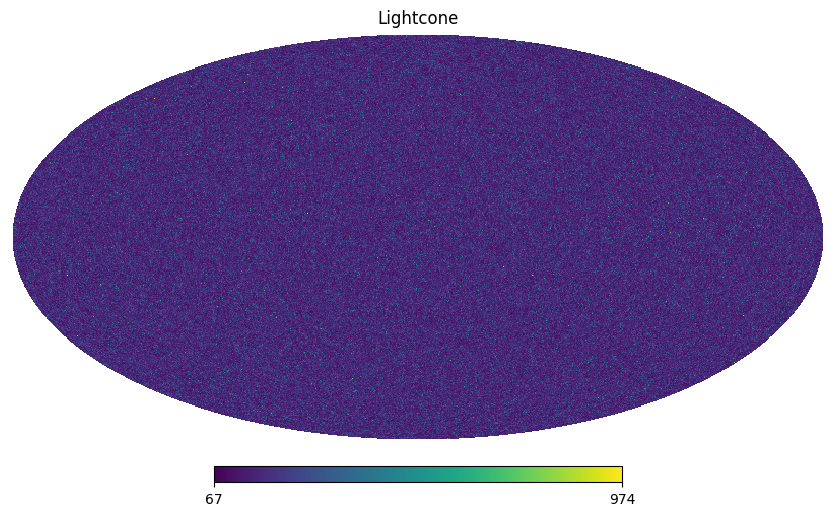

In [6]:
data = np.load(path, allow_pickle=True)

hp.mollview(data, title="Lightcone", cmap="viridis")
plt.show()

In [7]:
print("Number of objects in the lightcone: ", np.sum(data))

Number of objects in the lightcone:  9030967095


In [8]:
#Compute the density contrast
mean_pix = np.mean(data)
delta = data/mean_pix - 1

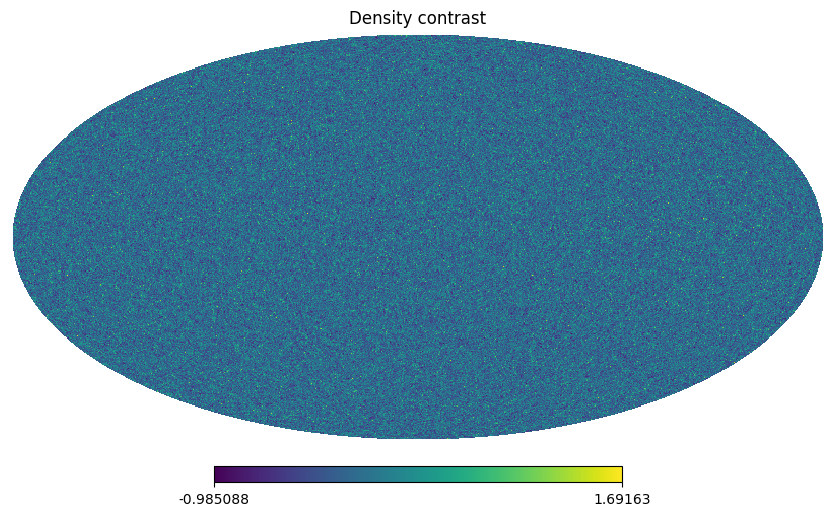

In [9]:
hp.mollview(np.log(1+delta), title="Density contrast", cmap="viridis")
plt.show()

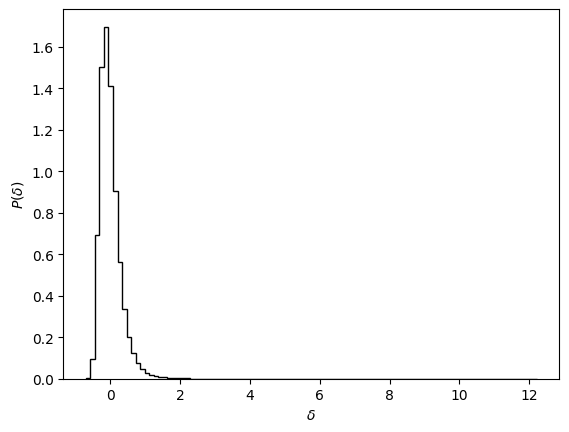

In [10]:
#PDF of the density contrast

plt.figure()

plt.hist(delta, bins=100, density=True, histtype="step", color="black")
plt.xlabel(r"$\delta$")
plt.ylabel(r"$P(\delta)$")
plt.show()

In [11]:
#Analyze the redshift distribution
path_exist, redshift_file = get_path_redshifts(sim)

print(f"The path {redshift_file} exists.") if path_exist else print(f"The path {redshift_file} does not exist. Check the path and try again.")

The path /n17data/sguerrini/GowerStreetSims/sim00001/z_values.txt exists.


In [12]:
redshifts = pd.read_csv(redshift_file, sep=",")
redshifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   # Step            100 non-null    int64  
 1   z_far             100 non-null    float64
 2   z_near            100 non-null    float64
 3   delta_z           100 non-null    float64
 4   cmd_far(Mpc/h)    100 non-null    float64
 5   cmd_near(Mpc/h)   100 non-null    float64
 6   delta_cmd(Mpc/h)  100 non-null    float64
 7   cmd/box_far       100 non-null    float64
 8   cmd/box_near      100 non-null    float64
 9   delta_cmd/box     100 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 7.9 KB


In [13]:
redshifts.head()


,# Step,z_far,z_near,delta_z,cmd_far(Mpc/h),cmd_near(Mpc/h),delta_cmd(Mpc/h),cmd/box_far,cmd/box_near,delta_cmd/box
0,1,49.00000,19.62800,29.37200,8470.535928,7593.780321,876.755607,6.776429,6.075024,0.701404
1,2,19.62800,13.28560,6.34240,7593.780321,7099.598583,494.181738,6.075024,5.679679,0.395345
2,3,13.28560,10.28740,2.99820,7099.598583,6731.627796,367.970787,5.679679,5.385302,0.294377
3,4,10.28740,8.48685,1.80055,6731.627796,6431.149236,300.478560,5.385302,5.144919,0.240383
4,5,8.48685,7.26564,1.22121,6431.149236,6173.781659,257.367577,5.144919,4.939025,0.205894


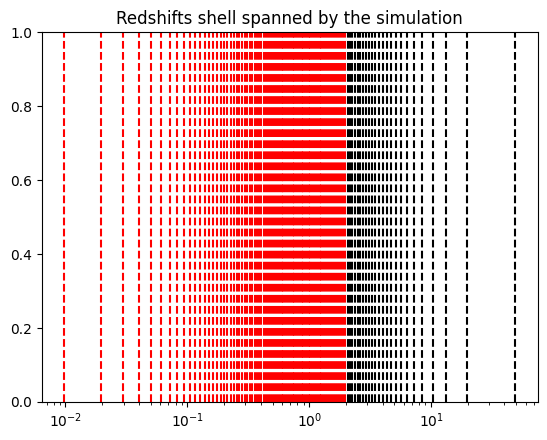

In [14]:
sim = 1

shells = []

plt.figure()

for step, z in enumerate(redshifts["z_far"]):
    path_exist, _ = get_path_lightcone(sim, step)
    if path_exist:
        shells.append(z)
    plt.axvline(x=z, color="black", linestyle="--") if not path_exist else \
        plt.axvline(x=z, color="red", linestyle="--")

shells.append(0.0)

shells = np.array(shells[::-1])

plt.title("Redshifts shell spanned by the simulation")
plt.xscale('log')
plt.show()

In [15]:
#Reproduce Figure 2 in Jeffrey et al.

sim = 1

density_contrast = np.zeros_like(data)

n_shell = 0
for step, z in tqdm(enumerate(redshifts["z_near"])):
    path_exist, path = get_path_lightcone(sim, step)
    if path_exist and z<0.15:
        gal_count_per_pix = np.load(path, allow_pickle=True)
        mean_pix = np.mean(gal_count_per_pix)
        delta = gal_count_per_pix/mean_pix - 1
        density_contrast = density_contrast + delta
        del delta
        n_shell += 1

print(f"Number of shells spanned: {n_shell}")
density_contrast /= n_shell

0it [00:00, ?it/s]

100it [00:05, 18.00it/s]

Number of shells spanned: 14


<Figure size 640x480 with 0 Axes>

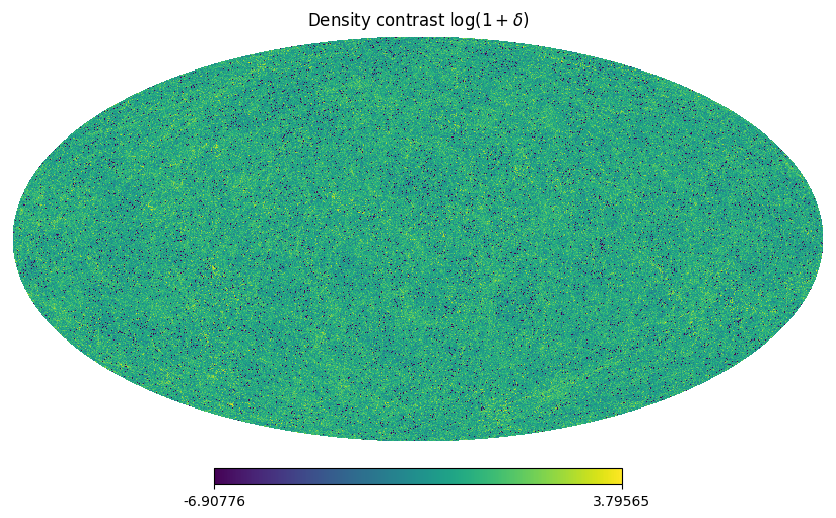

In [16]:
plt.figure()

cmap = LinearSegmentedColormap.from_list("mycmap", ["black", "gray"])

hp.mollview(np.log(1.001+density_contrast), title="Density contrast $\log(1+\delta)$", cmap="viridis")
plt.show()

In [17]:
#Building the convergence map using GLASS
import glass.fields
import glass.points
import glass.shapes
import glass.lensing
import glass.observations
import glass.galaxies
import glass.ext.camb
import camb
from classy import Class
from cosmology import Cosmology

from scipy.optimize import minimize_scalar

In [18]:
#Cosmo parameters config for the first simulation
h = 0.6998295678
Ob = 0.04547926293
Om = 0.3801089993
Oc = Om - Ob
sigma8 = 0.7657514029
w = -1.008941473
ns = 0.949651544
m_nu = 0.06

#Map params
nside = 512
lmax = 3*nside


#Optimization to have the value of As given a target value of sigma8
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=2.1e-9, WantTransfer=True)
results = camb.get_results(pars)

sigma8_comp = results.get_sigma8()
print(f"Computed sigma8: {sigma8_comp}")

def sigma8_difference(logAs):
    pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=np.exp(logAs), WantTransfer=True)
    results = camb.get_results(pars)
    return abs(results.get_sigma8() - sigma8)

res = minimize_scalar(sigma8_difference, bracket=[np.log(1e-9), np.log(3e-9)], tol=1e-10)
optimal_As = np.exp(res.x)

print(f"Optimal As: {optimal_As}")

Computed sigma8: [0.9821402]
Optimal As: [1.27657967e-09]


In [19]:
res

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1e-10 )
 success: True
     fun: [ 3.640e-11]
       x: [-2.048e+01]
     nit: 29
    nfev: 32

In [23]:
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=optimal_As, WantTransfer=True)

cosmo = Cosmology.from_camb(pars)

weights = glass.shells.tophat_windows(np.array([0.0, 0.01]), weight=glass.ext.camb.camb_tophat_weight)

In [24]:
try:
    cls = np.load("./pre_cls/cls_sim{:05d}_lmax{:}.npy".format(sim, lmax))
except FileNotFoundError:
    print(f"[!] The cls file for lmax={lmax} does not exist.")
    print(f"[!] Running the matter density cls calculation ...")
    cls = glass.ext.camb.matter_cls(pars, lmax, weights)
    np.save("./pre_cls/cls_sim{:05d}_lmax{:}.npy".format(sim, lmax), cls)
    print(f"[!] Done.")

[!] The cls file for lmax=1536 does not exist.
[!] Running the matter density cls calculation ...


In [ ]:
len(shells)*len(shells+1)/2

array([0.      , 0.009779, 0.019695, 0.029753, 0.039956, 0.050307,
       0.060811, 0.071471, 0.082292, 0.093278, 0.104434, 0.115765,
       0.127275, 0.138969, 0.150854, 0.162935, 0.175217, 0.187706,
       0.20041 , 0.213335, 0.226488, 0.239876, 0.253507, 0.26739 ,
       0.281532, 0.295942, 0.310631, 0.325607, 0.340881, 0.356465,
       0.372368, 0.388604, 0.405186, 0.422126, 0.439439, 0.457139,
       0.475244, 0.493768, 0.512731, 0.532151, 0.552048, 0.572443,
       0.593358, 0.614819, 0.63685 , 0.659479, 0.682734, 0.706648,
       0.731253, 0.756585, 0.782682, 0.809587, 0.837343, 0.865997,
       0.895603, 0.926214, 0.957892, 0.990703, 1.02472 , 1.06001 ,
       1.09667 , 1.13479 , 1.17447 , 1.21582 , 1.25896 , 1.30403 ,
       1.35117 , 1.40056 , 1.45238 , 1.50683 , 1.56414 , 1.62458 ,
       1.68843 , 1.75603 , 1.82776 , 1.90405 , 1.9854  ])

In [ ]:
#Setting up the lensing fields
z_lens = glass.matter.effective_redshifts(weights)
#lensing weights
wlens = glass.lensing.multi_plane_weights(z_lens, weights)

#The generatorfor the convergence field
convergence = glass.lensing.MultiPlaneConvergence(cosmo)